## 라이브러리 불러오기

In [1]:
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

2023-10-14 15:13:40.640210: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-14 15:13:40.641716: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-14 15:13:40.664564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-14 15:13:40.664588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-14 15:13:40.665197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0-dev20231005


## 데이터세트 불러오기

In [2]:
import pathlib
workspace_dir = '/home/shin/Graduation_Project/tensorflow_custom/tflite_model'
data_dir = '/home/shin/Graduation_Project/data/12_07_05/노지 작물 해충 진단 이미지/distributed_final/cropped/train'
data_dir = pathlib.Path(data_dir)
print(data_dir)

DIR = 'mobilenet_v3_test'

batch_size = 32
img_height = 96
img_width = 96

image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.JPG'))) +len(list(data_dir.glob('*/*.JPEG'))) + len(list(data_dir.glob('*/*.jpeg')))  
print(image_count)

/home/shin/Graduation_Project/data/12_07_05/노지 작물 해충 진단 이미지/distributed_final/cropped/train
4753


### 무잎벌 이미지 확인

In [3]:

bee = list(data_dir.glob('bee/*.jpg')) + list(data_dir.glob('bee/*.JPG')) + list(data_dir.glob('bee/*.JPEG')) + list(data_dir.glob('bee/*.jpeg'))
PIL.Image.open(str(bee[0]))



In [4]:
PIL.Image.open(str(bee[1]))

### 나방 이미지 확인

In [5]:
moth = list(data_dir.glob('moth/*.jpg')) + list(data_dir.glob('moth/*.JPG'))
PIL.Image.open(str(moth[0]))

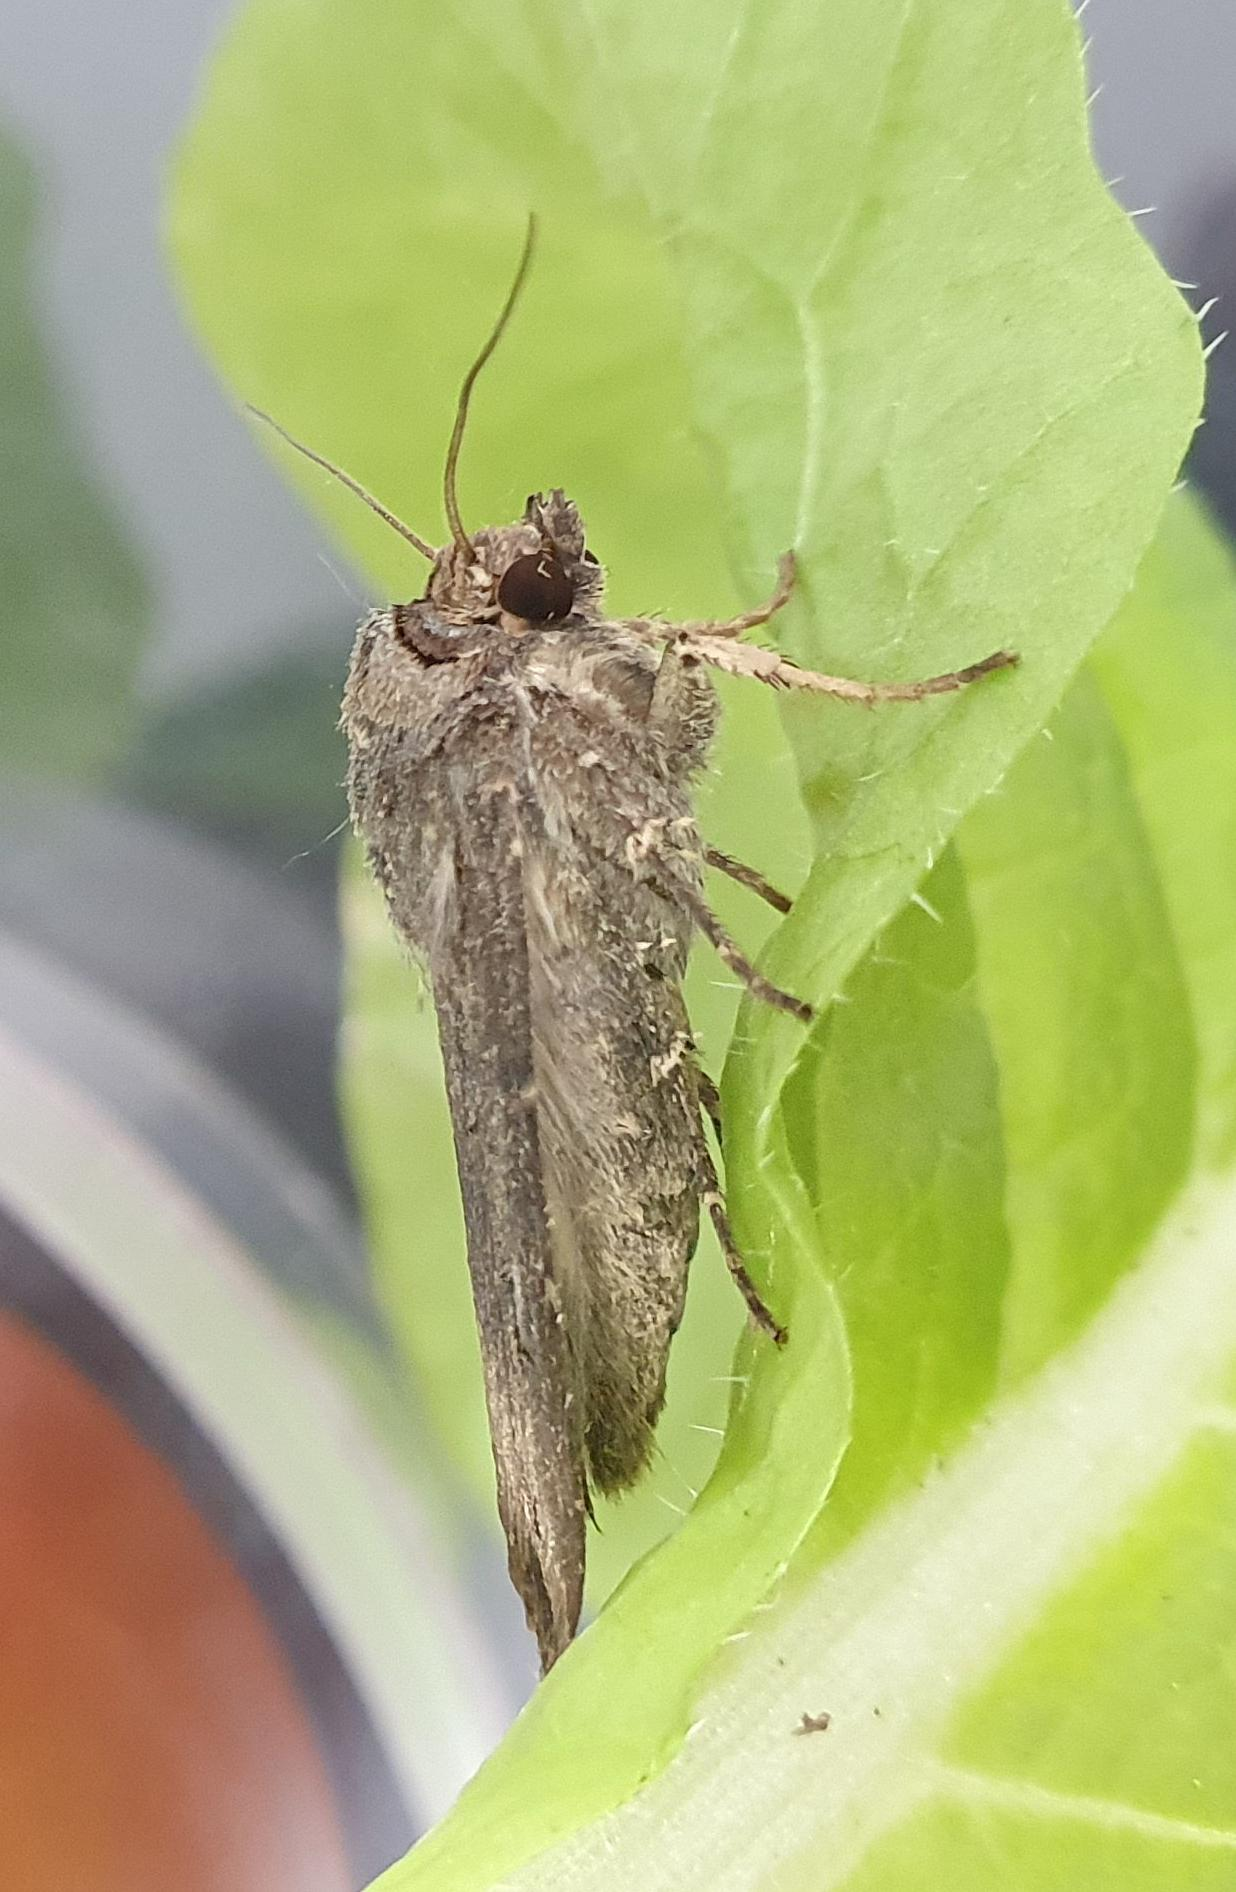

In [6]:
PIL.Image.open(str(moth[1]))

## 모델 생성

### 데이터세트 만들기

In [29]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  crop_to_aspect_ratio = True,
  interpolation='mitchellcubic',
  )


class_names = train_ds.class_names
print(class_names)


test_dir = '/home/shin/Graduation_Project/data/12_07_05/노지 작물 해충 진단 이미지/distributed_final/cropped/test'
test_ds= tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  crop_to_aspect_ratio = True
  )

Found 4753 files belonging to 5 classes.


Using 3803 files for training.
Using 950 files for validation.
['bee', 'butterfly', 'moth', 'stink', 'xxx']
Found 1192 files belonging to 5 classes.


### 데이터 시각화하기

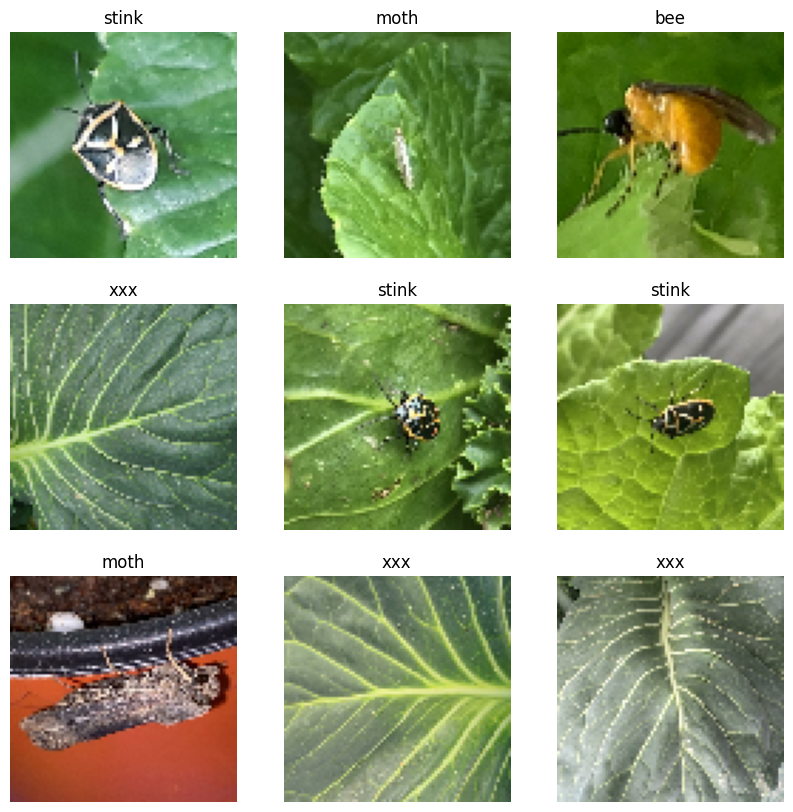

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 80, 80, 3)
(32,)


### 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련하는 동안 데이터 전처리 및 모델 실행을 중첩시킵니다.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 데이터 증강

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강 예제를 시각화합니다.

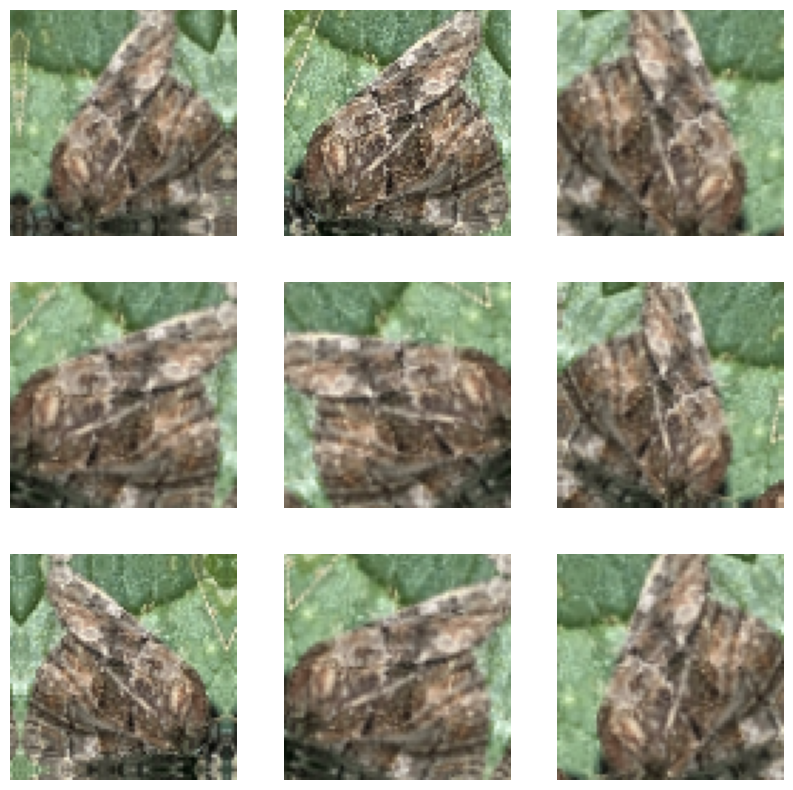

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### 모델 생성 및 요약

In [13]:
# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(4, 3, padding='same', activation='relu'),
#   layers.Conv2D(4, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(8, 3, padding='same', activation='relu'),
#   layers.Conv2D(8, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dropout(rate=0.8),
#   layers.Dense(num_classes, activation="softmax")
# ])

model = tf.keras.applications.MobileNetV3Small(
    input_shape=(80, 80, 3),
    alpha=0.5,
    minimalistic=False,
    include_top=True,
    weights=None,
    input_tensor=None,
    classes=5,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=False
)

model.summary()



Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 Conv (Conv2D)               (None, 40, 40, 16)           432       ['input_1[0][0]']             
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 40, 40, 16)           64        ['Conv[0][0]']                
 lization)                                                                                        
                                                                                                  
 tf.__operators__.add (TFOp  (None, 40, 40, 16)           0         ['Conv/BatchNor

### 모델 컴파일

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 학습

In [18]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/50
98/98 [==============================] - 4s 39ms/step - loss: 0.2170 - accuracy: 0.9234 - val_loss: 1.4002 - val_accuracy: 0.2784
Epoch 2/50
98/98 [==============================] - 4s 39ms/step - loss: 0.2841 - accuracy: 0.8970 - val_loss: 1.4299 - val_accuracy: 0.2784
Epoch 3/50
98/98 [==============================] - 4s 38ms/step - loss: 0.1836 - accuracy: 0.9366 - val_loss: 1.4649 - val_accuracy: 0.2784
Epoch 4/50
98/98 [==============================] - 4s 39ms/step - loss: 0.1954 - accuracy: 0.9315 - val_loss: 1.4705 - val_accuracy: 0.2784
Epoch 5/50
98/98 [==============================] - 4s 38ms/step - loss: 0.1563 - accuracy: 0.9479 - val_loss: 1.4760 - val_accuracy: 0.2784
Epoch 6/50
98/98 [==============================] - 4s 38ms/step - loss: 0.1027 - accuracy: 0.9653 - val_loss: 1.5568 - val_accuracy: 0.2784
Epoch 7/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0764 - accuracy: 0.9701 - val_loss: 1.5870 - val_accuracy: 0.2784
Epoch 8/50
98

In [19]:
model.evaluate(
    train_ds
)

98/98 [==============================] - 1s 13ms/step - loss: 0.0409 - accuracy: 0.9868


[0.04087427258491516, 0.9868082404136658]

### 모델 저장

In [22]:
export_dir = f'{workspace_dir}/saved_model/{DIR}'
tf.saved_model.save(model, export_dir)

# Keras 모델로 변환하기
# keras_model = tf.keras.models.Sequential(model.layers)

# # Keras 모델 저장하기
# keras_model.save(f'{workspace_dir}/saved_model/{DIR}/model.h5')

INFO:tensorflow:Assets written to: /home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/mobilenet_v3_test/assets


INFO:tensorflow:Assets written to: /home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/mobilenet_v3_test/assets


## TensorFlow Lite

### TensorFlow Lite 변환

In [23]:
# Convert the model.
tflite_model_path = f'{workspace_dir}/saved_model/{DIR}/saved_model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp1p2tkpw1/assets


INFO:tensorflow:Assets written to: /tmp/tmp1p2tkpw1/assets
2023-10-10 03:27:51.803636: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-10 03:27:51.803660: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-10 03:27:51.803908: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1p2tkpw1
2023-10-10 03:27:51.814440: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-10 03:27:51.814459: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1p2tkpw1
2023-10-10 03:27:51.835862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-10-10 03:27:51.846754: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-10 03:27:52.248142: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

### TensorFlow Lite 모델 PC에서 실행하여 확인하기

In [24]:
TF_MODEL_FILE_PATH = tflite_model_path # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

## 양자화

### representative_data_gen() 메서드 선언

In [25]:
numpy_arrays = []

for batch in train_ds:
    images, labels = batch
    for image in images:
      image_numpy = image.numpy()  # 이미지 배치를 NumPy 배열로 변환

      numpy_arrays.append(image_numpy)

print(len(numpy_arrays))
print(len(numpy_arrays[0]))
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(numpy_arrays).batch(1).take(100):
    yield [input_value]


3108
80


### 양자화 수행

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp3ct2z1gj/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ct2z1gj/assets
/home/shin/.conda/envs/tf11/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-10-10 03:28:20.219877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-10 03:28:20.219899: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-10 03:28:20.220023: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3ct2z1gj
2023-10-10 03:28:20.230804: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-10 03:28:20.230824: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3ct2z1gj
2023-10-10 03:28:20.260619: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-10 03:

### 양자화 모델 저장

In [27]:
tflite_model_quant_path = f'{workspace_dir}/saved_model/{DIR}/saved_model_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print(f"TensorFlow Lite 모델이 '{tflite_model_quant_path}'에 저장되었습니다.")

TensorFlow Lite 모델이 '/home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/mobilenet_v3_test/saved_model_quant.tflite'에 저장되었습니다.


In [9]:
import numpy as np
import tensorflow as tf

# TFLite 모델 파일 경로 설정
tflite_model_quant_path = f'{workspace_dir}/saved_model/{DIR}/saved_model_quant.tflite'

# TFLite 인터프리터 초기화
interpreter = tf.lite.Interpreter(model_path=tflite_model_quant_path)
interpreter.allocate_tensors()

# 입력 및 출력 텐서의 인덱스 가져오기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [14]:


# 정확도를 계산할 변수 초기화
correct_predictions = 0
total_predictions = 0

# 각 이미지에 대한 추론 실행 및 정확도 계산
for images, labels in test_ds:
    for i in range(len(images)):
        # 이미지를 TFLite 모델에 입력
        input_data = np.expand_dims(images[i], axis=0).astype(np.uint8)
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # 모델 실행
        interpreter.invoke()

        # 모델 출력 가져오기
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # 추론 결과에서 클래스 선택 (예시: 가장 높은 확률의 클래스 선택)
        predicted_class = np.argmax(output_data)

        # 실제 레이블과 비교하여 정확하게 분류된 경우 카운트
        if predicted_class == labels[i].numpy():
            correct_predictions += 1

        total_predictions += 1

# 정확도 계산
accuracy = correct_predictions / total_predictions
print("정확도:", accuracy)

정확도: 0.9026845637583892
